# This script processes the sycl results of the level study for different minRadius

1. Compile parallelgpu using stage1tbbrem :
```
make bin/parallelgpu
```
2. Run the benchmarking script that assesses a range of MinRadius and Level for nth=8 (see run_sycl_level script)
```
cd scripts
python3 run_sycl_minlevel
```
3. The output that we will process is sycl_minlev_coffee.csv



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize(filename):
    results ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            name=tokens[0].split("/")[3][:-5]
            minrad=float(tokens[2])
            level = int(tokens[4])
            if name not in results:
                results[name]={}
            if level not in results[name]:
                results[name][level]={}
            results[name][level][minrad]=[float(tokens[5])] # tree construction time
            results[name][level][minrad].append(float(tokens[6])) # tree copy time
            results[name][level][minrad].append(float(tokens[7])) # owm time
            results[name][level][minrad].append(float(tokens[11])) # accuracy

    #print(results)

    return results

res1=tokenize("sycl_minlev_coffee.csv")

#print(results)



In [16]:
#For Level=5 find the min and max accuracy for levels 3,4,5,6,7,8,9
print ("Cloud & Min accuracy & Max accuracy\\\\ \hline")
for i,k in zip(res1,[5]*4):
    accuracy=[res1[i][k][j][3] for j in [x/10 for x in list(range(1,19))]]
    minaccuracy=min(accuracy)
    maxaccuracy=max(accuracy)
    print ("{} & {:0.2f}\% & {:0.2f}\%\\\\ \hline".format(i,minaccuracy,maxaccuracy))

Cloud & Min accuracy & Max accuracy\\ \hline
Alcoy & 98.99\% & 99.75\%\\ \hline
Arzua & 98.04\% & 99.12\%\\ \hline
BrionF & 99.01\% & 99.43\%\\ \hline
BrionU & 98.95\% & 99.27\%\\ \hline


In [17]:
for i in res1:
    times=[res1[i][j][1][2] for j in res1[i]] # MinRadius=1
    mintime=min(times)
    minlev=np.argmin(times)
    print("Cloud {} with baseline level {} has  OWM time = {:.2f}".format(i,list(res1[i].keys())[0],res1[i][3][1][2] ))
    print("Cloud {} with best level {} has OWM best time (speedup) = {:.2f} ({:.2f}x)".format(i,list(res1[i].keys())[minlev],mintime ,res1[i][3][1][2]/mintime))


Cloud Alcoy with baseline level 3 has  OWM time = 0.21
Cloud Alcoy with best level 9 has OWM best time (speedup) = 0.19 (1.13x)
Cloud Arzua with baseline level 3 has  OWM time = 0.29
Cloud Arzua with best level 9 has OWM best time (speedup) = 0.18 (1.58x)
Cloud BrionF with baseline level 3 has  OWM time = 0.24
Cloud BrionF with best level 9 has OWM best time (speedup) = 0.10 (2.40x)
Cloud BrionU with baseline level 3 has  OWM time = 0.29
Cloud BrionU with best level 9 has OWM best time (speedup) = 0.11 (2.55x)


In [18]:
for i in res1:
    times=[res1[i][j][1][0] for j in res1[i]]
    mintime=min(times)
    minlev=np.argmin(times)
    print("Cloud {} with level {} has qtree creation best time = {:.2f}".format(i,list(res1[i].keys())[minlev],mintime ))


Cloud Alcoy with level 5 has qtree creation best time = 0.14
Cloud Arzua with level 5 has qtree creation best time = 0.24
Cloud BrionF with level 4 has qtree creation best time = 0.49
Cloud BrionU with level 4 has qtree creation best time = 0.54


In [20]:
for i in res1:
    times=[res1[i][j][1][0]+res1[i][j][1][1]+res1[i][j][1][2] for j in res1[i]] #MinRadius=1 OWM + qtree times
    mintime=min(times)
    minlev=np.argmin(times)
    baselinetotaltime=res1[i][3][1][0]+res1[i][3][1][1]+res1[i][3][1][2]
    print("Cloud {} with baseline level {} has total (8-core owm + qtree creation) time = {:.2f}".format(i,list(res1[i].keys())[0],baselinetotaltime ))
    print("Cloud {} with best level {} has total (8-core owm + qtree creation) best time (speedup) = {:.2f} ({:.2f}x)".format(i,list(res1[i].keys())[minlev],mintime ,baselinetotaltime/mintime))


Cloud Alcoy with baseline level 3 has total (8-core owm + qtree creation) time = 0.56
Cloud Alcoy with best level 5 has total (8-core owm + qtree creation) best time (speedup) = 0.47 (1.18x)
Cloud Arzua with baseline level 3 has total (8-core owm + qtree creation) time = 0.80
Cloud Arzua with best level 5 has total (8-core owm + qtree creation) best time (speedup) = 0.72 (1.11x)
Cloud BrionF with baseline level 3 has total (8-core owm + qtree creation) time = 1.24
Cloud BrionF with best level 4 has total (8-core owm + qtree creation) best time (speedup) = 1.18 (1.05x)
Cloud BrionU with baseline level 3 has total (8-core owm + qtree creation) time = 1.47
Cloud BrionU with best level 4 has total (8-core owm + qtree creation) best time (speedup) = 1.35 (1.09x)


# Execution time for each cloud with sycl version depending on level and minRadius

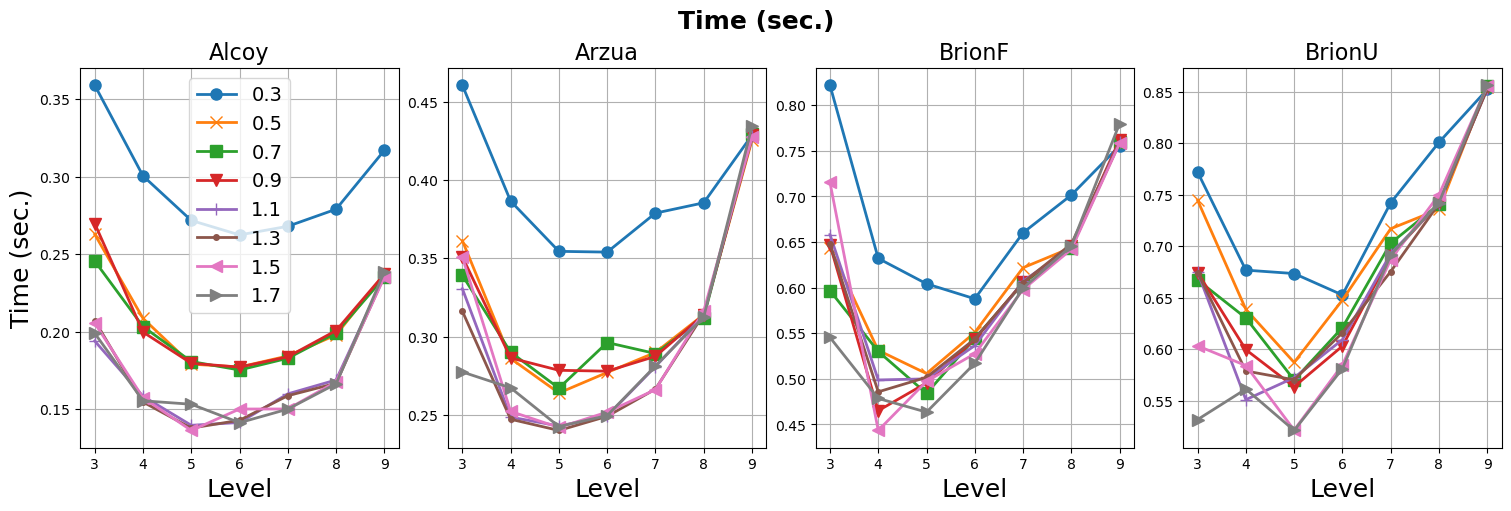

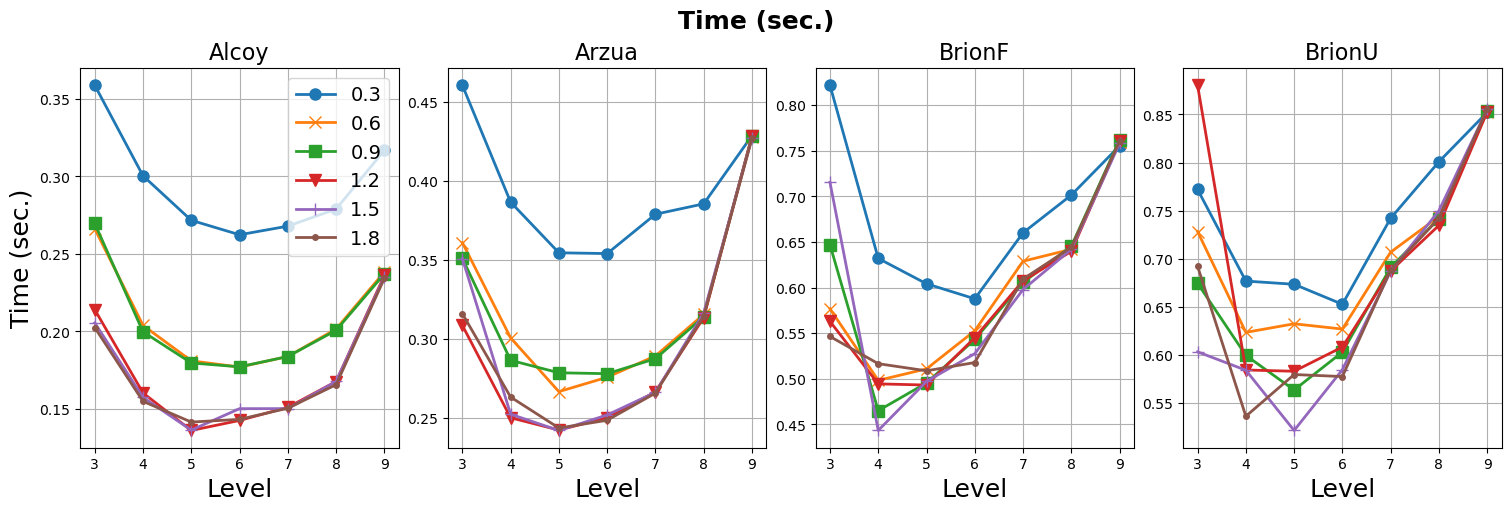

In [37]:
def plot_alltimes(step,results):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-','.-','<-','>-','1-','2-','3','4','8','p','h','H','*','D','d','|','_']

    #fig = plt.figure()
    labels=[x/10 for x in list(range(3,19,step))]
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        x=list(results[name].keys())
        for minrad,m in zip(labels,marks):
            axs[i].plot(np.array(x), np.array([results[name][i][minrad][0] for i in x]),m, linewidth=linew, markersize=markers)
        
        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Level', fontsize=xlabelfs)
        axs[i].set_xticks(x[::1],fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()


    fig.suptitle('Time (sec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    #axs[i].show()
    pp = PdfPages("MinRad-Level.pdf")
    pp.savefig(fig)
    pp.close()

plot_alltimes(2,res1)
plot_alltimes(3,res1)
